In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [56]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [57]:
print('Reading train dataset (Train 60000.cdb)...')
x_train, y_train = read_hoda_dataset(dataset_path='./dataset/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=False)


print('Reading test dataset (Test 20000.cdb)...')
x_test, y_test = read_hoda_dataset(dataset_path='./dataset/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)


print('Reading remaining samples dataset (RemainingSamples.cdb)...')
x_remaining, y_remaining = read_hoda_dataset('./dataset/RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=True,
                                             reshape=True)

Reading train dataset (Train 60000.cdb)...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Reading test dataset (Test 20000.cdb)...
Reading remaining samples dataset (RemainingSamples.cdb)...


In [58]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 1)



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 32, 32, 1, 1)
60000 train samples
20000 test samples


In [76]:
model = keras.Sequential()

model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32, 32, 1), padding="same"))
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='tanh'))
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))


model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_8 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_9 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_10 (Flatten)        (None, 576)               0         
                                                                 
 dense_13 (Dense)            (None, 120)             

In [60]:
x_test.shape

(20000, 32, 32, 1, 1)

In [61]:
y_test.shape

(20000, 10)

In [77]:
batch_size = 32
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/my_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[checkpoint_cb, early_stopping_cb ])
model = keras.models.load_model("./model/my_model.h5") # roll back to best model


Epoch 1/100
1688/1688 [==============================] - 10s 5ms/step - loss: 2.3029 - accuracy: 0.1014 - val_loss: 2.3023 - val_accuracy: 0.0983
Epoch 2/100
1688/1688 [==============================] - 9s 5ms/step - loss: 2.3025 - accuracy: 0.1014 - val_loss: 2.3025 - val_accuracy: 0.1012
Epoch 3/100
1688/1688 [==============================] - 9s 5ms/step - loss: 2.3018 - accuracy: 0.1063 - val_loss: 2.3017 - val_accuracy: 0.0925
Epoch 4/100
1688/1688 [==============================] - 9s 5ms/step - loss: 2.3003 - accuracy: 0.1130 - val_loss: 2.2998 - val_accuracy: 0.0945
Epoch 5/100
1688/1688 [==============================] - 9s 5ms/step - loss: 2.2970 - accuracy: 0.1367 - val_loss: 2.2950 - val_accuracy: 0.1587
Epoch 6/100
1688/1688 [==============================] - 9s 5ms/step - loss: 2.2845 - accuracy: 0.1862 - val_loss: 2.2666 - val_accuracy: 0.1227
Epoch 7/100
1688/1688 [==============================] - 9s 5ms/step - loss: 2.1271 - accuracy: 0.4304 - val_loss: 1.5999 - val_a

In [78]:
score = model.evaluate(x_test, y_test, verbose=True)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


625/625 [==============================] - 2s 4ms/step - loss: 0.0945 - accuracy: 0.9715
Test loss: 0.09450910985469818
Test accuracy: 0.9714999794960022


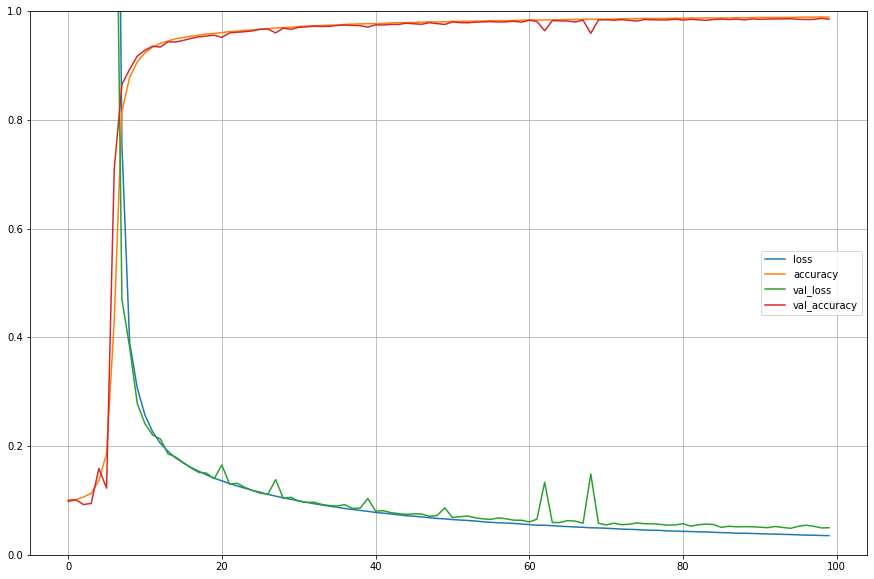

In [79]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.show()

In [80]:
x_new = x_test
y_proba = model.predict(x_new)
y_proba.round(2)

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.99, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.61, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.02, 0.  , ..., 0.  , 0.  , 0.88],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]], dtype=float32)

In [81]:
y_pred = model.predict(x_new)
y_pred


array([[9.9950838e-01, 1.0745341e-06, 5.4579050e-07, ..., 1.6346692e-05,
        1.3757775e-05, 1.5682188e-05],
       [9.9440777e-01, 1.7643197e-05, 2.6810611e-07, ..., 7.9649126e-06,
        3.3656132e-04, 3.3018418e-06],
       [6.0570782e-01, 4.4647548e-03, 3.0326876e-07, ..., 2.4363312e-03,
        1.1453624e-03, 2.6331567e-03],
       ...,
       [1.5776402e-04, 1.6329952e-02, 1.0173380e-03, ..., 5.0865060e-06,
        3.3371678e-06, 8.8408697e-01],
       [3.1765467e-07, 1.0683791e-07, 2.4178239e-06, ..., 7.7327526e-11,
        4.8934021e-06, 9.9985051e-01],
       [7.4466804e-08, 9.0657473e-09, 2.6005877e-05, ..., 4.4407292e-10,
        1.1516580e-06, 9.9951375e-01]], dtype=float32)

In [82]:
y_test[5000:5005]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [83]:
history.history

{'accuracy': [0.10137037187814713,
  0.10135184973478317,
  0.10633333027362823,
  0.11298148334026337,
  0.1366666704416275,
  0.18624074757099152,
  0.43037036061286926,
  0.8157592415809631,
  0.8779814839363098,
  0.9067962765693665,
  0.9234814643859863,
  0.9339073896408081,
  0.9410555362701416,
  0.9451666474342346,
  0.9493518471717834,
  0.9517592787742615,
  0.9540740847587585,
  0.9557592868804932,
  0.9582592844963074,
  0.9591110944747925,
  0.9605370163917542,
  0.9626666903495789,
  0.9632962942123413,
  0.9649074077606201,
  0.965499997138977,
  0.9667778015136719,
  0.9679074287414551,
  0.9691851735115051,
  0.969870388507843,
  0.9704444408416748,
  0.9716851711273193,
  0.9727222323417664,
  0.9732962846755981,
  0.9736666679382324,
  0.9745370149612427,
  0.9744259119033813,
  0.9757221937179565,
  0.976277768611908,
  0.9766481518745422,
  0.9769999980926514,
  0.977148175239563,
  0.9775370359420776,
  0.9784629344940186,
  0.9789259433746338,
  0.97890740633010

In [84]:
y_pred=model.predict(x_test) 
y_pred


array([[9.9950838e-01, 1.0745341e-06, 5.4579050e-07, ..., 1.6346692e-05,
        1.3757775e-05, 1.5682188e-05],
       [9.9440777e-01, 1.7643197e-05, 2.6810611e-07, ..., 7.9649126e-06,
        3.3656132e-04, 3.3018418e-06],
       [6.0570782e-01, 4.4647548e-03, 3.0326876e-07, ..., 2.4363312e-03,
        1.1453624e-03, 2.6331567e-03],
       ...,
       [1.5776402e-04, 1.6329952e-02, 1.0173380e-03, ..., 5.0865060e-06,
        3.3371678e-06, 8.8408697e-01],
       [3.1765467e-07, 1.0683791e-07, 2.4178239e-06, ..., 7.7327526e-11,
        4.8934021e-06, 9.9985051e-01],
       [7.4466804e-08, 9.0657473e-09, 2.6005877e-05, ..., 4.4407292e-10,
        1.1516580e-06, 9.9951375e-01]], dtype=float32)

In [85]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)